In [1]:
import os

os.environ['CUDA_VISIBLE_DEVICES'] = '1'

In [2]:
import sys

SOURCE_DIR = os.path.dirname(os.path.dirname(os.path.abspath(__name__)))
sys.path.insert(0, SOURCE_DIR)

In [3]:
import malaya_speech
import malaya_speech.config
from malaya_speech.train.model import revsic_glowtts as glowtts
import tensorflow as tf
import numpy as np
import math
import matplotlib.pyplot as plt

In [4]:
import pickle

with open('dataset-mel.pkl', 'rb') as fopen:
    data, d = pickle.load(fopen)
    
with open('dataset-mel-wav.pkl', 'rb') as fopen:
    wav = pickle.load(fopen)
    
data.keys()

dict_keys(['mel', 'text_ids', 'len_mel', 'len_text_ids', 'stop_token_target', 'f0', 'len_f0', 'energy', 'len_energy', 'g'])

In [5]:
i = tf.placeholder(tf.int32, [None, None])
i_lengths = tf.placeholder(tf.int32, [None])
mel_outputs = tf.placeholder(tf.float32, [None, None, 80])
mel_lengths = tf.placeholder(tf.int32, [None])
temperature = tf.placeholder(tf.float32, ())
length_scale = tf.placeholder(tf.float32, ())

In [6]:
config = glowtts.Config(mel = 80, vocabs = 66)
config.temperature = temperature
config.length_scale = length_scale

In [7]:
model = glowtts.Model(config)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [8]:
instance = malaya_speech.train.model.revsic_glowtts.flow.actnorm.ActNorm

for k in range(len(model.decoder.flows)):
    if isinstance(model.decoder.flows[k], instance):
        model.decoder.flows[k].init = 1

In [9]:
loss, losses, attn = model.compute_loss(text = i, textlen = i_lengths, mel = mel_outputs, mellen = mel_lengths)
loss, losses, attn

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


(<tf.Tensor 'add_4:0' shape=() dtype=float32>,
 {'nll': <tf.Tensor 'Mean:0' shape=() dtype=float32>,
  'durloss': <tf.Tensor 'Mean_1:0' shape=() dtype=float32>,
  'mel_': <tf.Tensor 'Reshape_2:0' shape=(?, ?, ?) dtype=float32>},
 <tf.Tensor 'StopGradient:0' shape=(?, ?, ?) dtype=float32>)

In [10]:
mel, mellen, attn_out = model(inputs = i, lengths = i_lengths)
mel, mellen, attn_out

(<tf.Tensor 'model/Reshape_50:0' shape=(?, ?, ?) dtype=float32>,
 <tf.Tensor 'model/mul_90:0' shape=(?,) dtype=int32>,
 <tf.Tensor 'model/transpose:0' shape=(?, ?, ?) dtype=float32>)

In [11]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

In [12]:
saver = tf.train.Saver()
saver.restore(sess, 'test/model.ckpt')

INFO:tensorflow:Restoring parameters from test/model.ckpt


In [13]:
o = sess.run([mel, mellen, attn_out], feed_dict = {i: [data['text_ids'][0]],
                                               i_lengths: [data['len_text_ids'][0,0]],
                                                  temperature: 0.1, length_scale: 1.0})

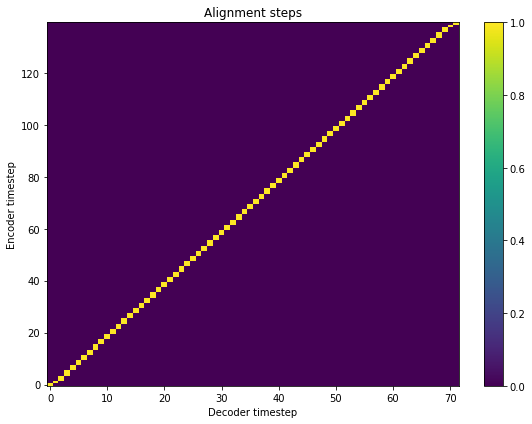

In [14]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)
ax.set_title('Alignment steps')
im = ax.imshow(
    o[-1][0],
    aspect='auto',
    origin='lower',
    interpolation='none')
fig.colorbar(im, ax=ax)
xlabel = 'Decoder timestep'
plt.xlabel(xlabel)
plt.ylabel('Encoder timestep')
plt.tight_layout()
plt.show()

In [15]:
o[0].shape, o[1]

((1, 280, 80), array([280], dtype=int32))

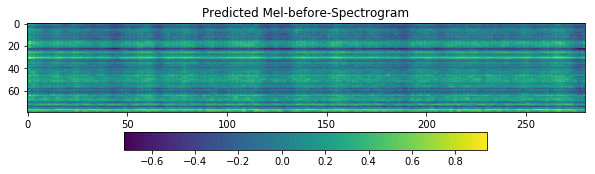

In [16]:
mel_outputs_ = np.reshape(o[0][0], [-1, 80])
fig = plt.figure(figsize=(10, 8))
ax1 = fig.add_subplot(311)
ax1.set_title(f'Predicted Mel-before-Spectrogram')
im = ax1.imshow(np.rot90(mel_outputs_), aspect='auto', interpolation='none')
fig.colorbar(mappable=im, shrink=0.65, orientation='horizontal', ax=ax1)
plt.show()

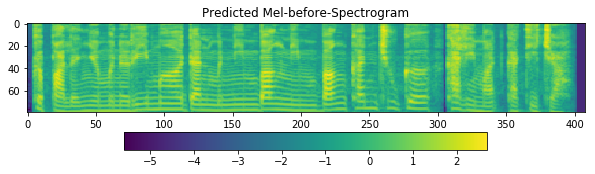

In [17]:
mel_outputs_ = np.reshape(data['mel'], [-1, 80])
fig = plt.figure(figsize=(10, 8))
ax1 = fig.add_subplot(311)
ax1.set_title(f'Predicted Mel-before-Spectrogram')
im = ax1.imshow(np.rot90(mel_outputs_), aspect='auto', interpolation='none')
fig.colorbar(mappable=im, shrink=0.65, orientation='horizontal', ax=ax1)
plt.show()